In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [2]:
activate_profiling = False
df_train = pd.read_csv("../data/data_train.csv")
df_test = pd.read_csv("../data/data_test.csv")
target = 'income'

In [3]:
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


In [4]:
if activate_profiling:
    profile = ProfileReport(df_train, title="Pandas Profiling Report")
    profile.to_file("../reports/train.html")
    profile = ProfileReport(df_test, title="Pandas Profiling Report")
    profile.to_file("../reports/test.html")

In [5]:
X_train = df_train.drop(target, axis=1)
y_train = df_train[target]

X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

In [6]:
rf_clf = RandomForestClassifier(criterion= 'gini', max_depth= 4, max_features= 3, min_samples_split= .0001, n_estimators= 7)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=3, min_samples_split=0.0001,
                       n_estimators=7)

In [7]:
rf_clf.score(X_test, y_test)

0.840366070880167

In [8]:
from sklearn.metrics import f1_score

In [9]:
f1_score(y_test, rf_clf.predict(X_test), zero_division=1)

0.5744227935156377

In [10]:
probs = rf_clf.predict_proba(X_test)

In [11]:
probs = probs[:, 1]

In [12]:
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)

AUC: 0.88


In [13]:
fpr, tpr, thresholds = roc_curve(y_test, probs)

In [14]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

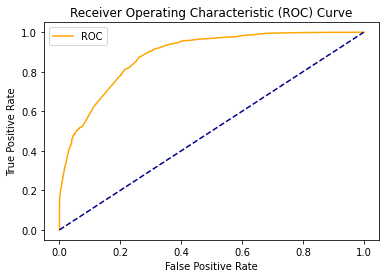

In [15]:
plot_roc_curve(fpr, tpr)

In [16]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
space =  {
        'type': 'RandomForestClassifier',
        'max_depth': hp.choice('max_depth', range(10,15)),
        'max_features': hp.choice('max_features', range(4,8)),
        'n_estimators': hp.choice('n_estimators', range(25,35)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'min_samples_split': hp.choice('min_samples_split', [.1,.01,.001,.0001])
    }

In [17]:
def objective(params):
    t = params.pop('type')
    test = eval(t)
    clf = test(**params)
    return cross_val_score(clf, X_train, y_train,cv=5).mean()

count = 0
best = 0

# Function to try and find the best parameters
def f(params):
    global best, count
    count += 1
    acc = objective(params.copy())
    if acc > best:
        print ('new best:', acc, 'using', params)
        best = acc
    if count % 50 == 0:
        print ('iters:', count, ', acc:', acc, 'using', params)
    return {'loss': -acc, 'status': STATUS_OK}

# Initializing hyperopt trials
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

new best:                                              
0.8619208898400516                                     
using                                                  
{'criterion': 'entropy', 'max_depth': 13, 'max_features': 4, 'min_samples_split': 0.0001, 'n_estimators': 27, 'type': 'RandomForestClassifier'}
new best:                                                                         
0.8630264324875103                                                                
using                                                                             
{'criterion': 'entropy', 'max_depth': 14, 'max_features': 4, 'min_samples_split': 0.001, 'n_estimators': 34, 'type': 'RandomForestClassifier'}
new best:                                                                          
0.8635792721870565                                                                 
using                                                                              
{'criterion': 'gini', 'max_depth': 13, 'max_

In [18]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}